<a href="https://colab.research.google.com/github/dhirenmalik/comp3710-demo-2/blob/main/COMP37102.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch

In [ ]:
# Download the data, if not already on disk and load it
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [ ]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)

X = torch.tensor(lfw_people.data, dtype=torch.float32)
n_features = X.shape[1]

# the label to predict is the id of the person
y = torch.tensor(lfw_people.target)
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
# Split into a training set and a test set using a stratified k fold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [ ]:
# Center data
mean = torch.mean(X_train, dim=0)
X_train_centered = X_train - mean
X_test_centered = X_test - mean

#Eigen-decomposition using SVD
U, S, V = torch.linalg.svd(X_train_centered, full_matrices=False)
components = V[:n_components]
eigenfaces = components.reshape((n_components, h, w))

#project into PCA subspace
X_transformed = torch.mm(X_train_centered, components.T)
print(X_transformed.shape)
X_test_transformed = torch.mm(X_test_centered, components.T)
print(X_test_transformed.shape)

torch.Size([966, 150])
torch.Size([322, 150])


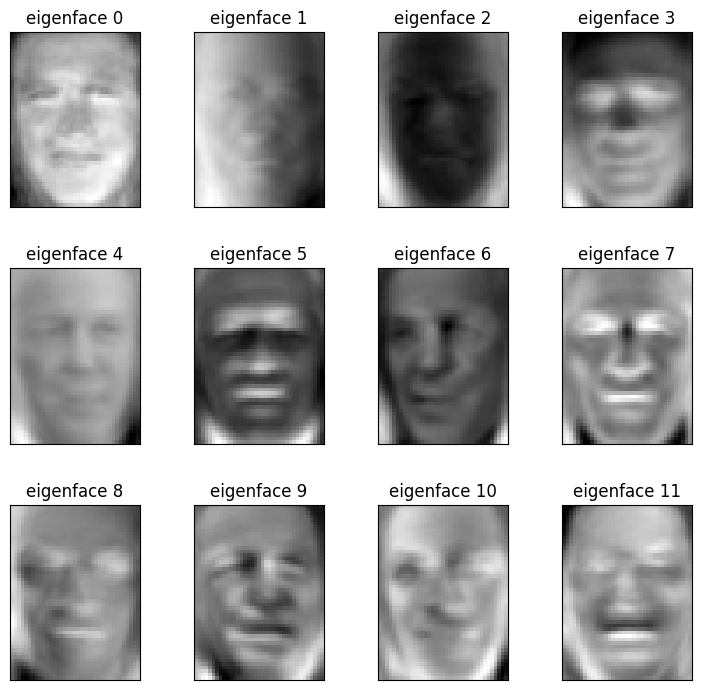

In [ ]:
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  """Helper function to plot a gallery of portraits"""
  plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces.cpu().numpy(), eigenface_titles, h, w)
plt.show()

torch.Size([966])


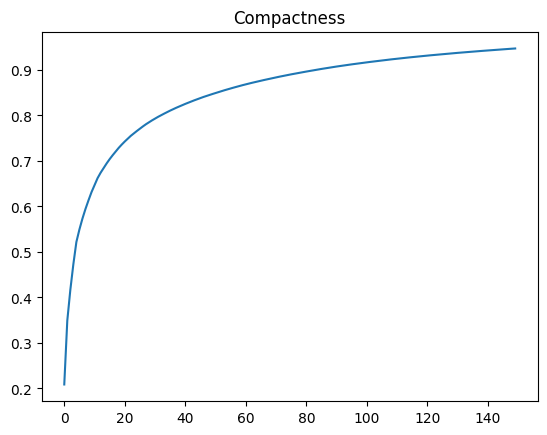

In [ ]:
explained_variance = (S ** 2) / (n_samples - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var
ratio_cumsum = torch.cumsum(explained_variance_ratio, dim=0)
print(ratio_cumsum.shape)
eigenvectorCount = np.arange(n_components)
plt.plot(eigenvectorCount, ratio_cumsum[:n_components].cpu().numpy())
plt.title('Compactness')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#build random forest
estimator = RandomForestClassifier(n_estimators=150, max_depth=15, max_features=150)
estimator.fit(X_transformed, y_train) #expects X as [n_samples, n_features]
predictions = estimator.predict(X_test_transformed)
correct = predictions==y_test
total_test = len(X_test_transformed)

In [ ]:
import numpy as np
import torch
from dataclasses import dataclass
from typing import Optional, Tuple

def _to_numpy(x: torch.Tensor) -> np.ndarray:
    # Move to CPU and get a contiguous float64/int64 array
    if x.is_cuda:
        x = x.cpu()
    arr = x.detach().numpy()
    # Ensure dtypes are friendly
    if arr.dtype.kind == 'f':
        return arr.astype(np.float64, copy=False)
    if arr.dtype.kind in ('i', 'u'):
        return arr.astype(np.int64, copy=False)
    return arr

@dataclass
class _Node:
    is_leaf: bool
    prediction: Optional[int] = None
    feature: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["__class__"] = None
    right: Optional["__class__"] = None

class DecisionTree:
    """
    Classification tree using Gini impurity.
    Split search is O(F * N log N) per node via (sort -> prefix class counts).
    """
    def __init__(
        self,
        max_depth: int = 10,
        min_samples_split: int = 2,
        max_features: Optional[int] = None,
        random_state: Optional[np.random.Generator] = None,
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features  # if None, set to sqrt(n_features) at fit
        self.rng = random_state if random_state is not None else np.random.default_rng()
        self.n_classes_ = None
        self.root_: Optional[_Node] = None

    def fit(self, X_torch: torch.Tensor, y_torch: torch.Tensor):
        X = _to_numpy(X_torch)
        y = _to_numpy(y_torch).astype(np.int64, copy=False)

        self.n_classes_ = int(np.max(y)) + 1
        n_features = X.shape[1]
        if self.max_features is None:
            self.max_features_ = max(1, int(np.sqrt(n_features)))
        else:
            self.max_features_ = min(n_features, self.max_features)

        indices = np.arange(X.shape[0], dtype=np.int64)
        self.root_ = self._build_node(X, y, indices, depth=0)
        return self

    def _leaf(self, y_idx: np.ndarray) -> _Node:
        # Majority class
        counts = np.bincount(y_idx, minlength=self.n_classes_)
        return _Node(is_leaf=True, prediction=int(np.argmax(counts)))

    @staticmethod
    def _gini(counts: np.ndarray) -> float:
        # counts = class counts in a node
        n = counts.sum()
        if n == 0:
            return 0.0
        p = counts / n
        return 1.0 - np.sum(p * p)

    def _best_split_for_feature(
        self, x_col: np.ndarray, y_sub: np.ndarray
    ) -> Tuple[Optional[float], float]:
        """
        Given a single feature column x_col and corresponding labels y_sub for current node,
        find best threshold (between sorted distinct values) minimizing weighted Gini.
        Returns (threshold, impurity). If no valid split, (None, +inf).
        """
        # Sort by feature
        order = np.argsort(x_col, kind='stable')
        x_sorted = x_col[order]
        y_sorted = y_sub[order]

        # Candidates are boundaries between distinct consecutive x values
        diff = np.diff(x_sorted)
        valid = diff > 0
        if not np.any(valid):
            return None, float('inf')

        # Prefix class counts L[k] = counts for y_sorted[:k+1]
        # Build cumulative counts for all classes efficiently
        counts_total = np.bincount(y_sorted, minlength=self.n_classes_).astype(np.int64, copy=False)
        # Build prefix counts by scanning y_sorted
        # Use 2D prefix: rows = positions, cols = classes
        # Efficient approach: accumulate per position for the class of that position
        prefix = np.zeros((y_sorted.size, self.n_classes_), dtype=np.int64)
        prefix[0, y_sorted[0]] = 1
        for i in range(1, y_sorted.size):
            prefix[i] = prefix[i-1]
            prefix[i, y_sorted[i]] += 1

        best_impurity = float('inf')
        best_pos = -1

        # Evaluate splits at positions where x changes: split after position i (left = 0..i, right = i+1..end)
        # We must exclude trivial splits (all left or all right)
        positions = np.nonzero(valid)[0]  # positions where boundary between i and i+1 is valid
        n = y_sorted.size

        for i in positions:
            left_counts = prefix[i]
            right_counts = counts_total - left_counts
            nL = i + 1
            nR = n - nL
            if nL == 0 or nR == 0:
                continue
            gL = self._gini(left_counts)
            gR = self._gini(right_counts)
            impurity = (nL * gL + nR * gR) / n
            if impurity < best_impurity:
                best_impurity = impurity
                best_pos = i

        if best_pos == -1:
            return None, float('inf')

        # Threshold halfway between x_sorted[best_pos] and x_sorted[best_pos+1]
        thr = 0.5 * (x_sorted[best_pos] + x_sorted[best_pos + 1])
        return float(thr), float(best_impurity)

    def _choose_split(
        self, X: np.ndarray, y: np.ndarray, idx: np.ndarray
    ) -> Tuple[Optional[int], Optional[float]]:
        # Random feature subset (feature bagging)
        n_features = X.shape[1]
        feat_indices = self.rng.choice(n_features, size=self.max_features_, replace=False)

        y_sub = y[idx]
        best_feature = None
        best_threshold = None
        best_impurity = float('inf')

        for f in feat_indices:
            x_col = X[idx, f]
            thr, imp = self._best_split_for_feature(x_col, y_sub)
            if thr is not None and imp < best_impurity:
                best_impurity = imp
                best_feature = f
                best_threshold = thr

        return best_feature, best_threshold

    def _build_node(self, X: np.ndarray, y: np.ndarray, idx: np.ndarray, depth: int) -> _Node:
        # Stop conditions
        y_sub = y[idx]
        n_samples = idx.size
        if (
            depth >= self.max_depth
            or n_samples < self.min_samples_split
            or np.unique(y_sub).size == 1
        ):
            return self._leaf(y_sub)

        feature, threshold = self._choose_split(X, y, idx)
        if feature is None:
            return self._leaf(y_sub)

        # Partition
        x_col = X[idx, feature]
        left_mask = x_col <= threshold
        right_mask = ~left_mask

        # Safety: if degenerate, make leaf
        if not np.any(left_mask) or not np.any(right_mask):
            return self._leaf(y_sub)

        left_idx = idx[left_mask]
        right_idx = idx[right_mask]

        left_node = self._build_node(X, y, left_idx, depth + 1)
        right_node = self._build_node(X, y, right_idx, depth + 1)

        return _Node(
            is_leaf=False,
            prediction=None,
            feature=int(feature),
            threshold=float(threshold),
            left=left_node,
            right=right_node,
        )

    def predict(self, X_torch: torch.Tensor) -> torch.Tensor:
        X = _to_numpy(X_torch).astype(np.float64, copy=False)
        preds = np.empty(X.shape[0], dtype=np.int64)
        for i in range(X.shape[0]):
            preds[i] = self._predict_one(self.root_, X[i])
        return torch.from_numpy(preds)

    def _predict_one(self, node: _Node, x: np.ndarray) -> int:
        while not node.is_leaf:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction



In [ ]:
class RandomForest:
    """
    CPU-optimized Random Forest Classifier.
    - Bootstrapping on indices
    - Feature bagging inside trees (sqrt by default)
    - NumPy core for split/search speed, returns torch tensors for convenience
    """
    def __init__(
        self,
        n_estimators: int = 100,
        max_depth: int = 10,
        min_samples_split: int = 2,
        max_features: Optional[int] = None,  # None -> sqrt(d)
        random_state: Optional[int] = None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.rng = np.random.default_rng(random_state)
        self.trees = []

    def fit(self, X_torch: torch.Tensor, y_torch: torch.Tensor):
        X = _to_numpy(X_torch).astype(np.float64, copy=False)
        y = _to_numpy(y_torch).astype(np.int64, copy=False)

        n_samples = X.shape[0]
        self.trees = []
        for _ in range(self.n_estimators):
            # Bootstrap sample
            indices = self.rng.integers(0, n_samples, size=n_samples, endpoint=False)

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features,
                random_state=np.random.default_rng(self.rng.integers(0, 2**31 - 1)),
            )
            tree.fit(torch.from_numpy(X[indices]), torch.from_numpy(y[indices]))
            self.trees.append(tree)
        return self

    def predict(self, X_torch: torch.Tensor) -> torch.Tensor:
        # Collect predictions from all trees (NumPy for speed)
        X = _to_numpy(X_torch).astype(np.float64, copy=False)
        all_preds = np.stack([t.predict(torch.from_numpy(X)).numpy() for t in self.trees], axis=0)  # (n_estimators, n_samples)

        # Majority vote via bincount per column
        n_estimators, n_samples = all_preds.shape
        out = np.empty(n_samples, dtype=np.int64)
        for j in range(n_samples):
            out[j] = np.bincount(all_preds[:, j]).argmax()
        return torch.from_numpy(out)

In [ ]:
# Check for GPU availability and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#SCRATCHT THAT WE GOING CPU
device = torch.device('cpu')
print(f"Using device: {device}")

# Move data to the chosen device
X_transformed = X_transformed.to(device)
y_train = y_train.to(device)
X_test_transformed = X_test_transformed.to(device)
y_test = y_test.to(device)


# Train the Random Forest model on the chosen device
rf_model = RandomForest(n_estimators=100, max_depth=10, min_samples_split=5)
rf_model.fit(X_transformed, y_train)

# Make predictions on the test set
predictions = rf_model.predict(X_test_transformed)

# Evaluate the model (move predictions and y_test to CPU for classification_report if they are on GPU)
correct = (predictions == y_test).sum().item()
total_test = y_test.shape[0]
accuracy = correct / total_test

print(f"Total Testing: {total_test}")
print(f"Total Correct: {correct}")
print(f"Accuracy: {accuracy:.4f}")
# Ensure tensors are on CPU for classification_report
print(classification_report(y_test.cpu().numpy(), predictions.cpu().numpy(), target_names=target_names))

Using device: cuda
Using device: cpu
Total Testing: 322
Total Correct: 177
Accuracy: 0.5497
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.71      0.40      0.51        60
  Donald Rumsfeld       1.00      0.11      0.20        27
    George W Bush       0.52      0.99      0.68       146
Gerhard Schroeder       0.75      0.12      0.21        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       1.00      0.06      0.11        36

         accuracy                           0.55       322
        macro avg       0.57      0.24      0.24       322
     weighted avg       0.62      0.55      0.45       322



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#print("Gnd Truth:", y_test)
print("Total Testing", total_test)
print("Predictions", predictions)
print("Which Correct:",correct)
print("Total Correct:",np.sum(correct))
print("Accuracy:",np.sum(correct)/total_test)
print(classification_report(y_test, predictions, target_names=target_names))

Total Testing 322
Predictions tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
        3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 4, 3, 3,
        1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1,
        3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1,
        3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 3, 3, 1,
        3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3,
        3,

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
